# NYPD Allegations

# Summary of Findings


### Introduction
In my first project with this dataset, I analyzed whether the severeness of the officer's punishment was significantly correlated with the complainant being a different gender from the officer. A big portion of the data was unusable due to the missingness in the complainant gender column however, which may have had an impact on the permutation test. 

To remedy such a possible bias in data, I will create a classifier to predict the gender of the complainant given the other features in the nypd data. Because of the disproportion between males and females in the complainant_gender feature, I will evaluate the f1-score of the model because we want the model to accurately the rare case of the complainant being female.

We also decide that the classifier predicts **1 for female, and 0 for male**.

### Baseline Model
We fit a DecisionTreeClassifier. The model takes in 13 features, in which 3 are quantitative, 1 is ordinal, and 9 are nominal.

### Final Model
We engineer three new features:
- age scaled by precinct, which may work due to different precincts having different ages and populations
- old_age classified by complainants over 60, as the older the age, the more likely the complainant is female.
- Binarized age difference, where age differences over 10 are more likely to be female than the rest of the differences.

We also determine the best depth for the DecisionTreesClassifier, and also determine other models, which all perform worse than the classifier.

### Fairness Evaluation
We evaluate whether the model is fair for complainants that were arrested and not arrested, using the difference in accuracy as our test statistic. We use accuracy because if the model uses the outcome as a significant factor in determining gender, there should be a big gap in accuracy. 

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [2]:
import re

In [3]:
from lab import StdScalerByGroup
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
%load_ext autoreload
%autoreload 2

In [4]:
nypd = pd.read_csv(os.path.join('data', 'allegations.csv'))
nypd.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


#### Data cleaning

For simplification, we will transform any transgender to their declared gender, Not Described will be turned into a null value, and non-conforming gender will be dropped as there is not enough data to generalize this as its own respective gender.

In [5]:
nypd.complainant_gender.value_counts(dropna=False)

Male                     24058
Female                    5021
NaN                       4195
Not described               57
Transwoman (MTF)            20
Transman (FTM)               5
Gender non-conforming        2
Name: complainant_gender, dtype: int64

In [6]:
nypd.complainant_gender = nypd.complainant_gender.replace({
    'Not described': np.NaN,
    'Transwoman (MTF)': 'Female',
    'Transman (FTM)': 'Male'
})

nypd = nypd[nypd.complainant_gender != 'Gender non-conforming']
nypd.complainant_gender.value_counts(dropna=False)

Male      24063
Female     5041
NaN        4252
Name: complainant_gender, dtype: int64

We also need to clean precinct and complainant_age_incident for suspected invalid values.

In [7]:
# Replace non-existent precincts
nypd.precinct = nypd.precinct.replace(to_replace=[0., 22., 1000.], value=np.NaN)
# We also need to fix the age column for invalid values (mainly the -4301 value)
nypd.complainant_age_incident = nypd.complainant_age_incident.apply(lambda x: x if x > 12 else np.NaN)

In [8]:
# Other possible features to use later on:
nypd['age_difference'] = nypd.complainant_age_incident - nypd.mos_age_incident

### Baseline Model

Firstly, we must pick our features. We can rule out a lot that are not useful, in which I list some reasons why such data can't/shouldn't be used:
- ```unique_mos_id``` - Not useful
- ```first_name```
- ```last_name```
- ```command_now``` - Many are unable to be one-hot encoded, and many are also fairly correlated with precinct.
- ```shield_no``` - 
- ```complaint_id``` - Not useful for generating new data.
- ```command_at_incident``` - Hard to fit into a useful feature
- ```rank_abbrev_incident``` - Hard to fit into a useful feature
- ```rank_abbrev_now``` - Hard to fit into a useful feature
- ```allegation``` - Cannot be one hot encoded easily, but may be useful for identifying physical contact with complainant.
- ```contact_reason```
- ```month_closed``` - month close should not be related to gender at all
- ```year_closed``` - year close should not be related to gender at all


 
**We will use these features, which are split into categories:**

Numerical:
- ```year_received``` - Numerical
- ```mos_age_incident``` - Numerical
- ```complainant_age_incident``` - Numerical

Ordinal:
- ```board_disposition```

Categorical:
- ```month_received``` - Categorical due to not having a great numerical relationship (January isn't supposed to 12x less the value as December)
- ```rank_now``` 
- ```rank_incident```  
- ```mos_ethnicity```  
- ```mos_gender``` 
- ```complainant_ethnicity```  
- ```complainant_gender``` 
- ```precinct```  (precinct isn't exactly ordered)
- ```fado_type``` 
- ```outcome_description``` - simplified in dataframe because not possible in sklearn

In [9]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, FunctionTransformer, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, confusion_matrix, f1_score

We have a lot of unique categorical data, so we should one-hot encode a good portion of the data.

In [10]:
def get_outcome(outcome):
    if pd.isnull(outcome) or outcome.startswith('No arrest'):
        return 'No arrest'
    elif re.search('Arrest', outcome):
        return 'Arrest'
    else:
        return 'Semi-Crime'

In [11]:
nypd['outcome_simple'] = nypd.outcome_description.apply(get_outcome)

#### Feature pipeline

In [12]:
numericals = ['year_received', 'mos_age_incident', 'complainant_age_incident']

# Categoricals to one hot encode excluding rank now and rank incident
ohe_generics = ['month_received', 
                'mos_ethnicity', 
                'mos_gender', 
                'complainant_ethnicity',
                'precinct',
                'fado_type',
                'outcome_simple'] 

# Rank categories which only have 8 options
rank_categories = ['rank_now', 'rank_incident']
possible_ranks = nypd.rank_incident.unique()

# Ordinal encoding of disposition
disposition_order = [
    'Unsubstantiated',
    'Substantiated (No Recommendations)',
    'Substantiated (MOS Unidentified)',
    'Substantiated (Formalized Training)',
    'Substantiated (Instructions)',
    'Substantiated (Command Lvl Instructions)',
    'Substantiated (Command Discipline)',
    'Substantiated (Command Discipline A)',
    'Substantiated (Command Discipline B)',
    'Substantiated (Charges)',
    'Exonerated'
]

In [13]:
# Numerical values to impute
numeric_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values=np.NaN, fill_value=0))
])

# Categorical one hot encoder
categorical_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

disposition_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[disposition_order]))
])

# Feature pipeline for all categories
feature_pipeline = ColumnTransformer([
    ('standardizer', numeric_pipeline, numericals),
    ('disposition', disposition_pipeline, ['board_disposition']),
    ('ohe_ranks', OneHotEncoder(categories=[possible_ranks, possible_ranks]), rank_categories),
    ('ohe_gen', categorical_pipeline, ohe_generics)
])

#### **Splitting by time-series: why?**

One thing to note is that a single complainant can file multiple reports, and that randomly shuffling the data can possibly have the same complainant within the training and test data, leading to the chance for the model to yield a good score with overfitting.

Therefore, we should not shuffle the data before splitting in order to capture new complainants specifically. We will assume that new complainants will emerge in future data (which should already be ordered by time) in order for the training data to be completely separate from the test data.

The downside to this is that the train test split will not split randomly anymore, which can be fine for our initial baseline model, in which we can also kfold it later on. 

In [14]:
valid_data = nypd[~nypd.complainant_gender.isnull()]
X = valid_data.drop(columns=['complainant_gender'])
y = (valid_data.complainant_gender == 'Female').astype(int)

In [15]:
# This one complainant has 30 complaints filed!
nypd[nypd.complaint_id == 36901].shape[0]

30

In [16]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Create pipeline
basic_model = Pipeline([
    ('feat_processor', feature_pipeline),
    ('decisiontree', DecisionTreeClassifier())
])

# Fit model
basic_model.fit(x_train, y_train);

f1_score(y_test, basic_model.predict(x_test))

0.27427356484762583

**Model precision score**

In [17]:
confusion_matrix(y_test, basic_model.predict(x_test))

array([[4841, 1042],
       [1006,  387]])

### Final Model

We have found a good depth for this basic model, but we must still find a good depth for the final model with newly-engineered features.

I have created two different hypotheses:
- Precinct scaling the age may make sense due to different precincts having different age populations, which can possibly be linked to gender ratios. 
- There is a trend towards women at older ages ( about >40), so we should binarize older ages in order to account for such a change in rate.

In [18]:
from sklearn.ensemble import RandomForestClassifier

I have also tried many other models that do not perform as well:
- LogisticRegression - heavily biased towards male
- LinearSVC - naively predicts male always
- KNearestClassifier - f1 score is worse than DecisionTrees
- RandomForestClassifier - same as KNearest

Text(0.5, 1.0, 'Age Difference')

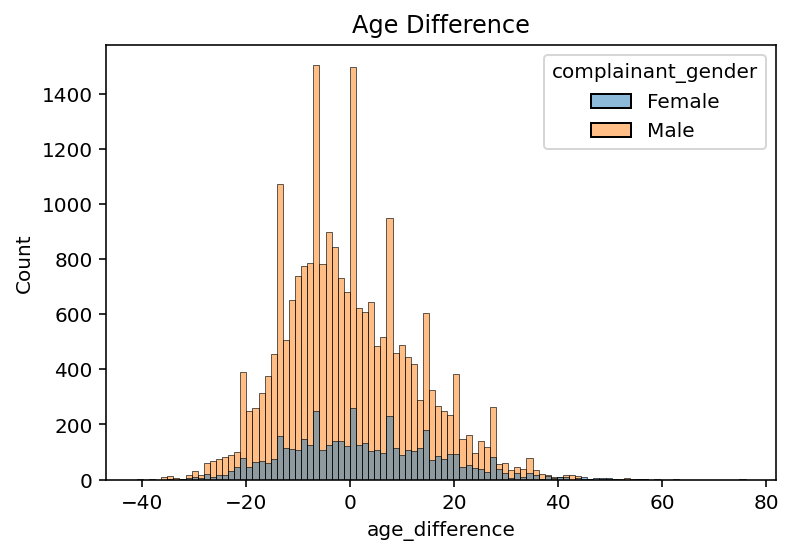

In [19]:
# Trend towards older age for women
ax = sns.histplot(data=nypd, x='age_difference', hue='complainant_gender')
ax.set_title('Age Difference')

<AxesSubplot:xlabel='complainant_age_incident', ylabel='Count'>

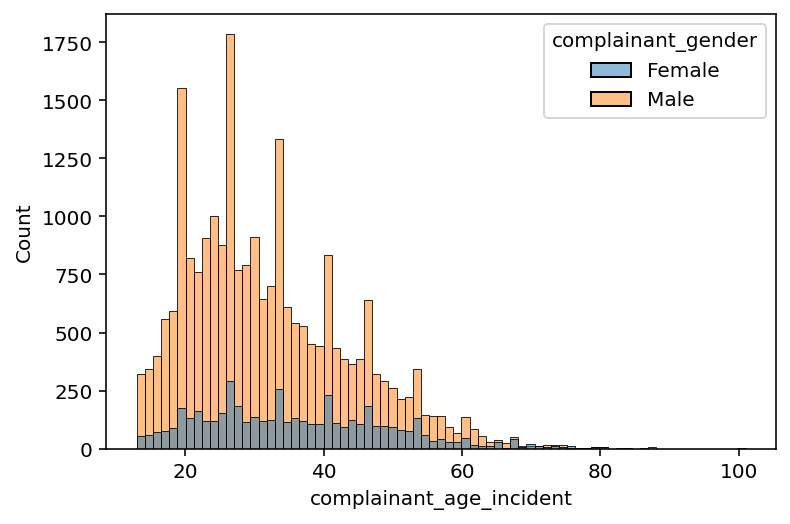

In [20]:
sns.histplot(data=nypd, x='complainant_age_incident', hue='complainant_gender')

In [21]:
nypd.groupby('precinct').complainant_age_incident.describe()

,count,mean,std,min,25%,50%,75%,max
precinct,,,,,,,,
1.0,163.0,36.128834,12.923396,16.0,25.00,35.0,45.00,87.0
5.0,152.0,31.197368,10.835336,14.0,25.00,28.0,39.00,63.0
6.0,160.0,39.706250,13.658272,16.0,30.00,38.0,48.00,101.0
7.0,179.0,31.340782,10.599505,13.0,24.00,29.0,36.00,62.0
9.0,229.0,35.231441,11.489647,14.0,27.00,33.0,44.00,63.0
...,...,...,...,...,...,...,...,...
115.0,212.0,32.094340,13.072911,14.0,22.00,28.0,38.25,75.0
120.0,750.0,32.241333,11.749915,13.0,22.00,30.0,40.00,72.0
121.0,341.0,34.208211,12.630986,15.0,25.00,31.0,44.00,73.0


In [22]:
# New Features
precinct_pipeline = Pipeline([
    ('imputator', SimpleImputer(fill_value=0)),
    ('stdscalegroup', StdScalerByGroup())
])

binarize_age_pipeline = Pipeline([
    ('imputation', SimpleImputer(fill_value=0)),
    ('binarize', Binarizer(threshold=50))
])

binarize_age_diff = Pipeline([
    ('imputation', SimpleImputer(fill_value=0)),
    ('binarize', Binarizer(threshold=10))
])





# Numerical values to impute
numeric_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values=np.NaN, fill_value=0))
])

# Categorical one hot encoder
categorical_pipeline = Pipeline([
    ('imputation', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

disposition_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=[disposition_order]))
])


# Feature pipeline for all categories
new_feature_pipeline = ColumnTransformer([
    ('standardizer', numeric_pipeline, numericals),
    ('disposition', disposition_pipeline, ['board_disposition']),
    ('ohe_ranks', OneHotEncoder(categories=[possible_ranks, possible_ranks]), rank_categories),
    ('ohe_gen', categorical_pipeline, ohe_generics),
    # New features!
    ('prec_std', precinct_pipeline, ['precinct', 'complainant_age_incident']),
    ('age_bin', binarize_age_pipeline, ['complainant_age_incident']),
    ('age_diff', binarize_age_diff, ['age_difference'])
])

We also need to find which parameters are the best for the DecisionTree. I have determined that higher min_sample_splits will only result in lower test scores, so I did not consider it. For the most part, the best performing depth is around the 50s.

In [23]:
results = {}

for max_depth in range(50, 55):       
        # Create pipeline
        final_classifier = Pipeline([
            ('feat_processor', new_feature_pipeline),
            ('decisiontree', DecisionTreeClassifier(max_depth=max_depth))
        ])
        scores = []
        for i in range(5):
            # Average out f1 score
            final_classifier.fit(x_train, y_train);
            scores.append(f1_score(y_test, final_classifier.predict(x_test)))
            
        # Add to results
        results[max_depth] = np.mean(scores)
            
max(results, key=lambda x: results[x])

53

In [24]:
final_classifier = Pipeline([
            ('feat_processor', new_feature_pipeline),
            ('decisiontree', DecisionTreeClassifier(max_depth=53))
        ])
final_classifier.fit(x_train, y_train);
f1_score(y_test, final_classifier.predict(x_test))

0.26758520667150104

In [25]:
confusion_matrix(y_test, final_classifier.predict(x_test))

array([[4887,  996],
       [1024,  369]])

These three features slightly boost the overall f1-score of the model.

### Fairness Evaluation

One of the features that we used is the outcome discription, which labeled whether there were any possible arrests, which includes summons due to involuntary movement/action. We wish to determine whether if the complainant was arrested whether gender is biased, which should not happen due to ethics.

- Null hypothesis: The precision between arrested and not arrested figures are the same, and the model is fair.
- Alternative hypothesis: The precision between the arrested and not arrested figures are not the same, and the model is unfair.
- I will also use a p-value of .05.

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
outcome_fair = (x_test[['outcome_simple']] != 'No arrest').replace({True: 'Arrested', False: 'Not arrested'})
outcome_fair['prediction'] = final_classifier.predict(x_test)
outcome_fair['actual'] = y_test
outcome_fair = outcome_fair.rename(columns={'outcome_simple':'arrested'})
outcome_fair

,arrested,prediction,actual
25168,Arrested,0,0
25169,Arrested,0,0
25170,Arrested,0,0
25171,Arrested,0,0
25172,Arrested,0,0
...,...,...,...
33353,Arrested,0,0
33354,Arrested,0,0
33355,Arrested,0,0
33356,Arrested,0,0


In [28]:
observed = (
    outcome_fair
    .groupby('arrested')
    .apply(lambda x: accuracy_score(x.actual, x.prediction))
    .diff()
    .abs()
    .iloc[-1]
)
observed

0.030189372363925493

In [29]:
differences = []
# Permutation test of prediction
for i in range(1000):
    
    mean_diff = (
        outcome_fair
        .assign(arrested=np.random.permutation(outcome_fair.arrested))
        .groupby('arrested')
        .apply(lambda x: accuracy_score(x.actual, x.prediction))
        .diff()
        .abs()
        .iloc[-1]
    )
    differences.append(mean_diff)

Text(0.5, 0, 'Category Accuracy Difference')

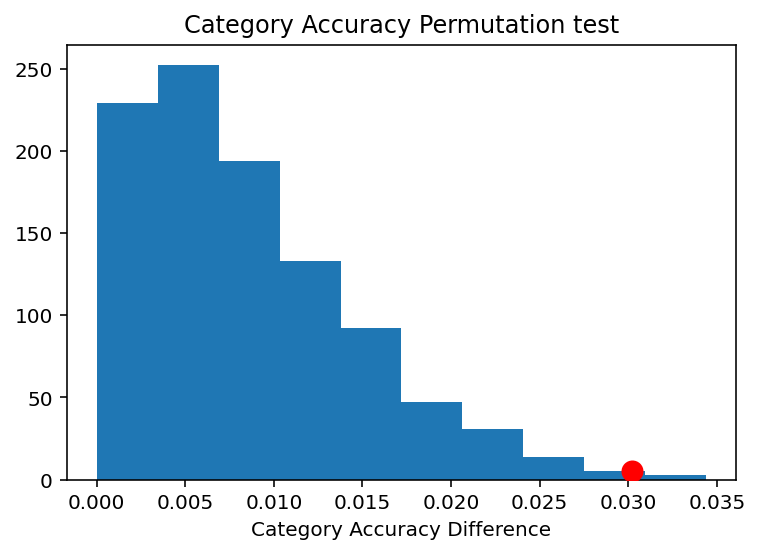

In [30]:
ax = plt.hist(differences)
plt.scatter(x=observed, y=5, zorder=3, color='red', s=100)
plt.title('Category Accuracy Permutation test')
plt.xlabel('Category Accuracy Difference')

In [31]:
(observed < differences).mean()

0.003

From this observed p-value, we determine that the model is unfair for whether the complainant was arrested.